In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import cv2

In [3]:
print(tf.__version__)

1.14.0


## Reading the data 

###### Auxiliary functions

In [4]:
class Bidict(dict):
    def __init__(self, *args, **kwargs):
        super(Bidict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value,[]).append(key) 

    def __setitem__(self, key, value):
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(Bidict, self).__setitem__(key, value)
        self.inverse.setdefault(value,[]).append(key)        

    def __delitem__(self, key):
        self.inverse.setdefault(self[key],[]).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(Bidict, self).__delitem__(key)

In [5]:
def readCSV(path):
    #Read the csv file and transform it to a list
    list_csv = pd.read_csv(path, sep=';', header=None) 
    list_csv = list_csv.values.tolist()
    
    return list_csv

In [6]:
def getSamples(list_csv, name_to_label, annot_dict, nb_samples):
    ''' Return all the samples chosen as a list of tuples
        - list_csv:           List of all the row readed from the csv
        - name_to_label:      Dictionary whitch maps the gesture name to its annotation
        - annot_dict:         Dictionary whitch maps the annotations to its samples 
        - nb_samples:         List containing number of validation samples wanted for each class
        - samples:            List of all the samples represented by tuples chosen(dir_name, class)
    '''

    #Feed the annot_dict, each entry will consist of
    #a class number as a key and a list of tuples(dir_number, class)
    for i in range(len(list_csv)):
        idx = name_to_label[list_csv[i][1]]
        num = list_csv[i][0]
    
        annot_dict[idx].append((num, idx))
    
    #choice randomly nb_samples[i] of each category and concatenate 
    #all the samples in only one list
    samples = []
    for key, value in annot_dict.items():
        nums = random.choices(value, k=nb_samples[key])
        samples = samples + nums
        
    #Shuffle the list 
    #random.shuffle(validation_samples)
    
    #make the dir_number and its corresponding label in different lists
    #validation_nums = [v[0] for v in validation_samples]
    #validation_labels = [v[1] for v in validation_samples]
    
    #use one-hot encoding
    #validation_labels_categorical = tf.keras.utils.to_categorical(validation_labels, num_classes=len(labels),dtype='float32')
    
    return samples

In [7]:
def createSamples(path_labels, path_train, path_validation, nb_samples_train, nb_samples_val, nb_samples_test):
    ''' Return the samples that will be used for training and testing
        - Path_labels:      Path to the labels csv file
        - Path_train:       Path to the train set csv file
        - Path_validation:  Path to the validation set file 
        
        * nb_samples:       Tuple containing in the first value the number of samples to be chosen 
                            for each class, excepts for the doing nothing category whitch the number
                            of samples to be chosen is represented in the second value of the tuple
                            
        - nb_samples_train: Number of samples for the training set
        - nb_samples_val:   Number of samples for the validation set
        - nb_samples_test:  Number of samples for the test set 
    '''
    
    labels = pd.read_csv(path_labels, sep=';', header=None)
    
    #create the name_to_label dict to map the class names to its annotations
    #create the train, validation and test annotation dicts
    name_to_label = {}
    validation_dict = {}
    train_dict = {}
    test_dict = {}
    for i in range(len(labels)):
        name_to_label[labels.values[i].tolist()[0]] = i
        train_dict[i] = []
        validation_dict[i] = []
        test_dict[i] = []
    
    #create a list of 27 values, where each value
    #corresponds to the number of samples to be chosen
    #randomly for that class
    nb_samples_t = [nb_samples_train[0]]*26 + [nb_samples_train[1]]
    nb_samples_v = [nb_samples_val[0]]*26 + [nb_samples_val[1]]
    nb_samples_tt = [nb_samples_test[0]]*26 + [nb_samples_test[1]]
    
    #split the train into train and test as the test csv do not provide annotations
    train_csv = readCSV(path_train)
    test_csv = train_csv[100000:]
    train_csv = train_csv[:100000]
    
    #Read the samples for each set
    train_samples = getSamples(train_csv, name_to_label, train_dict, nb_samples_t)
    validation_samples = getSamples(readCSV(path_validation), name_to_label, validation_dict, nb_samples_v)
    test_samples = getSamples(test_csv, name_to_label, test_dict, nb_samples_tt)
    
    vocab = Bidict(name_to_label)
    
    return train_samples, validation_samples, test_samples, vocab

In [89]:
def display_gesture(dir_path, samples, nb_samples, class_label):
    ini = class_label*nb_samples[0]
    if(class_label < 26):
        final = ini + nb_samples[0]
    else:
        final = ini + nb_samples[1]
    
    choice = random.choice(samples[ini:final])
    
    dir_path = os.path.join(dir_path, str(choice[0]))
    paths = os.listdir(dir_path)


    if(len(paths) > nb_frames):
        offset = len(paths) - nb_frames
        paths = paths[offset:]
    else:
        offset = nb_frames - len(paths)
        for i in range(offset):
            paths.append(paths[-1])

    fig = plt.figure(figsize=(10,10))
    fig.suptitle(vocab.inverse[class_label], fontsize=20)
    for i, p in enumerate(paths):
        path = os.path.join(dir_path,p)
    
        frame = cv2.imread(path)
        frame = cv2.resize(frame, (img_rows, img_cols), interpolation=cv2.INTER_AREA)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        x = fig.add_subplot(6,5,i+1)
        x.imshow(frame_gray, cmap='gray')

In [93]:
nb_samples_train = (10, 20)
nb_samples_val = (10, 20)
nb_samples_test = (10,20)

img_rows = 64
img_cols = 64
nb_frames = 30
dataset_path = '/media/cfcv/Daniel Alencar/jester/20bn-jester-v1'

In [9]:
train_samples, val_samples, test_samples, vocab = createSamples(path_labels='CSV/jester-v1-labels.csv',
                                                         path_train='CSV/jester-v1-train.csv',
                                                         path_validation='CSV/jester-v1-validation.csv',
                                                         nb_samples_train=nb_samples_train,
                                                         nb_samples_val=nb_samples_val, 
                                                         nb_samples_test=nb_samples_test)
print('Train samples: ', len(train_samples))
print('Validation samples: ', len(val_samples))
print('Test samples: ', len(test_samples))

Train samples:  280
Validation samples:  280
Test samples:  280


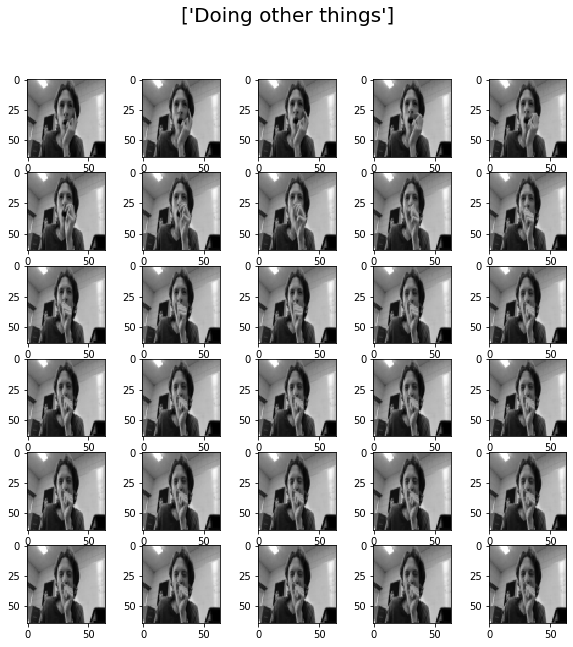

In [90]:
display_gesture('/media/cfcv/Daniel Alencar/jester/20bn-jester-v1',train_samples, nb_samples_train, class_label=26)

In [120]:
def batch_generator(train_samples, batch_size, is_training):
    X = np.empty([batch_size, nb_frames, img_rows, img_cols, 1])
    Y = np.empty([batch_size, num_classes])

    index_vector =list(range(len(train_paths)))
    current_exemple = 0
    new_epoch = False
    
    if(is_training):
        random.shuffle(index_vector)
        
    while(True):
        if(new_epoch and is_training):
            random.shuffle(index_vector)
            new_epoch = False
            current_exemple = 0
        
        annotations = []
        for i in range(batch_size):
            sample = train_samples[index_vector[current_exemple]]
            dir_number = sample[0]
            annotations.append(sample[1])
            
            dir_path = os.path.join(DATASET_PATH, str(dir_number))
            image_paths = os.listdir(dir_path)
            
            if(len(image_paths) > NB_FRAMES):
                offset = len(image_paths)
        
        current_example += 1
        if(current_example == len(train_paths)):
            new_epoch = True
            current_example = 0
    
    annotations = []
    for sample in train_samples[:30]:
        dir_number = sample[0]
        annotations.append(sample[1])

        dir_path = os.path.join(dataset_path, str(dir_number))
        image_paths = os.listdir(dir_path)


        if(len(image_paths) > nb_frames):
            offset = len(image_paths) - nb_frames
            image_paths = image_paths[offset:]
        else:
            offset = nb_frames - len(image_paths)
            for i in range(offset):
                image_paths.append(image_paths[-1])

        for i, p in enumerate(image_paths):
            path = os.path.join(dir_path,p)

            frame = cv2.imread(path)
            frame = cv2.resize(frame, (img_rows, img_cols), interpolation=cv2.INTER_AREA)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            X[0,i,:,:,0] = frame_gray

    cat = tf.keras.utils.to_categorical(annotations, num_classes=num_classes,dtype='float32')

In [ ]:
  index_vector = list(range(len(train_paths)))
  current_example = 0
  new_epoch = False
  
  if(is_training):
    #First shuffle
    random.shuffle(index_vector)
  
  while True:
    if(new_epoch and is_training):
      random.shuffle(index_vector)
      new_epoch = False
      current_example = 0
    
    for index in range(batch_size):
      path = train_paths[index_vector[current_example]]
      input_stack, CI_stack = load_mat(path)
      
      #normalize
      if(input_normalization):
        X[index] = normalization(input_stack)
      else:
        X[index] = input_stack
      
      Y[index] = CI_stack[:,:,0].reshape(INPUT_HEIGHT, INPUT_WIDTH, 1)
      
      current_example += 1
      if(current_example == len(train_paths)):
        new_epoch = True
        current_example = 0
        
    yield X, Y

In [122]:
print(X.shape)

(30, 30, 64, 64, 1)


In [121]:
cat.shape

(30, 27)

In [130]:
model = CNN3D_LSTM()

In [131]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 64, 64, 1)]   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 30, 64, 64, 16)    1216      
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 64, 64, 16)    64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 15, 32, 32, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 15, 32, 32, 32)    13856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 32, 32, 32)    128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 7, 16, 16, 32)     0     

In [132]:
hist = model.fit(
    X,
    cat,
    batch_size=8,
    epochs = 3,
    shuffle=True,)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/3
30/30 [==============================] - 15s 508ms/sample - loss: 3.3287 - acc: 0.1333
Epoch 2/3
30/30 [==============================] - 15s 488ms/sample - loss: 3.0623 - acc: 0.3000
Epoch 3/3
30/30 [==============================] - 14s 482ms/sample - loss: 2.6008 - acc: 0.3667


## Creating the model 

In [129]:
def CNN3D_LSTM():
    inputs = tf.keras.Input(shape=(nb_frames, img_rows, img_cols, 1))
    
    conv1 = tf.keras.layers.Conv3D(16, kernel_size=(3,5,5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    bn1 = tf.keras.layers.BatchNormalization()(conv1)
    maxp1 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(bn1)
    
    conv2 = tf.keras.layers.Conv3D(32, kernel_size=(3,3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(maxp1)
    bn2 = tf.keras.layers.BatchNormalization()(conv2)
    maxp2 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(bn2)
    
    lstm = tf.keras.layers.ConvLSTM2D(40, (3,3))(maxp2)
    flatten = tf.keras.layers.Flatten()(lstm)
    
    d1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(d1)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return model

## Training  

In [ ]:
def batch_generator(train_paths, batch_size, is_training, input_normalization = False):
  X = np.empty([batch_size, INPUT_HEIGHT, INPUT_WIDTH, INPUT_DEPTH])
  Y = np.empty([batch_size, INPUT_HEIGHT, INPUT_WIDTH, 1])
  
  index_vector = list(range(len(train_paths)))
  current_example = 0
  new_epoch = False
  
  if(is_training):
    #First shuffle
    random.shuffle(index_vector)
  
  while True:
    if(new_epoch and is_training):
      random.shuffle(index_vector)
      new_epoch = False
      current_example = 0
    
    for index in range(batch_size):
      path = train_paths[index_vector[current_example]]
      input_stack, CI_stack = load_mat(path)
      
      #normalize
      if(input_normalization):
        X[index] = normalization(input_stack)
      else:
        X[index] = input_stack
      
      Y[index] = CI_stack[:,:,0].reshape(INPUT_HEIGHT, INPUT_WIDTH, 1)
      
      current_example += 1
      if(current_example == len(train_paths)):
        new_epoch = True
        current_example = 0
        
    yield X, Y

In [ ]:
def train(model, modelName, batch_size, val_batch_size, epochs, train_paths, valid_paths):
  checkPoint = ModelCheckpoint(modelName, monitor='val_loss', save_best_only=True)
  
  it_per_epoch = np.ceil(len(train_paths) / batch_size)
  val_per_epoch = np.ceil(len(valid_paths) / val_batch_size)
  
  history = model.fit_generator(batch_generator(train_paths, batch_size, is_training=True, input_normalization = False), 
                                steps_per_epoch=it_per_epoch,
                                epochs=epochs,
                                verbose=1,
                                callbacks=[checkPoint],
                                validation_data=batch_generator(valid_paths, batch_size=val_batch_size, is_training=False, input_normalization = False),
                                validation_steps=val_per_epoch)
  
  return history

## Testing 